## Player Value Testing: League Ranking

In [251]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from nba_api.stats.static import players

In [14]:
print('reading data')
data_2021 = pd.read_csv('test_data/2021_fantasy_scores.csv')
data_2020 = pd.read_csv('test_data/2020_fantasy_scores.csv')
data_2021 = data_2021[['player_name','player_id','matchup','game_date','fantasy_score','fantasy_score_cumul']]
data_2020 = data_2020[['player_name','player_id','matchup','game_date','fantasy_score','fantasy_score_cumul']]

print('concatenating data')
data = pd.concat([data_2020, data_2021])
data = data.sort_values(by=['player_id','game_date']).reset_index(drop=True)

# expensive code atm. need to refactor using numpy arrays or regular lists
def n_game_avg(row, n=10):
    n_games = (data[['game_date','player_id','fantasy_score']]
                   .loc[(data['game_date'] <= row['game_date']) & (data['player_id'] == row['player_id'])]
                   .sort_values(by='game_date', ascending=False)
                   .head(n+1))
    return np.mean(n_games['fantasy_score'].tail(n)), np.mean(n_games['fantasy_score'].head(n))

print('calculating averages...')
# this takes forever. so get it over w/
data_2021['n_game_avg'], data_2021['inclusive_avg'] = zip(*data_2021.apply(lambda x: n_game_avg(x), axis=1))

reading data
concatenating data
calculating averages...


In [146]:
import datetime as dt
start = dt.datetime.strptime(min(data_2021['game_date']), '%Y-%m-%d').date()
end = dt.datetime.strptime(max(data_2021['game_date']), '%Y-%m-%d').date()
day_diff = abs(start-end).days
dates = [str(start + dt.timedelta(days=t)) for t in range(day_diff+1)]

In [151]:
plyrs = list(data_2021['player_id'].unique())
plyr_date = []
for p in plyrs:
    for d in dates:
        plyr_date.append((p,p,d))

In [253]:
player_dict = {p['id']:p['full_name'] for p in players.get_active_players()}

In [208]:
test = (pd.DataFrame(plyr_date, columns=['pid','player_id','game_date'])
            .merge(data_2021, on=['player_id','game_date'], how='left')
            .drop(['matchup','fantasy_score','fantasy_score_cumul'],axis=1)
            .groupby('pid') # pid gets removed
            .transform(lambda x: x.fillna(method='ffill')))
test.columns = ['player_id','date','player_name','n_game_avg','inclusive_avg']

In [249]:
test['rank'] = (test.sort_values(by=['date','inclusive_avg'], ascending=[True,False])
                    .groupby(['date']).cumcount()+1)
test['player_name'] = test['player_id'].apply(lambda x: player_dict[x])

In [325]:
def rank_c(a, b):
    if a == b or np.isnan(a) or np.isnan(b):
        return 0
    def f(x):
        return .85/(math.e**(0.085*x)) + 0.15
    
    a = int(a)
    b = int(b)
    sign = 1 if a > b else -1
    x_range = range(a, b+1) if a < b else range(b, a+1)
    return round(sign * sum([f(x) for x in x_range]),4)

In [ ]:
test['prev_rank'] = (test.sort_values(by=['date'], ascending=True)
                         .groupby(['player_id'])['rank'].shift(1))
test['rank_score'] = test.apply(lambda x: rank_c(x['prev_rank'],x['rank']), axis=1)

enter player:  victor oladipo


29.099999999999998


,player_id,date,player_name,n_game_avg,inclusive_avg,rank,prev_rank,rank_score
18803,203506,2021-10-30,Victor Oladipo,NaN,NaN,434,429.0,-0.90
18804,203506,2021-10-31,Victor Oladipo,NaN,NaN,434,434.0,0.00
18805,203506,2021-11-01,Victor Oladipo,NaN,NaN,437,434.0,-0.60
18806,203506,2021-11-02,Victor Oladipo,NaN,NaN,438,437.0,-0.30
18807,203506,2021-11-03,Victor Oladipo,NaN,NaN,441,438.0,-0.60
...,...,...,...,...,...,...,...,...
18961,203506,2022-04-06,Victor Oladipo,9.85,12.60,272,270.0,-0.45
18962,203506,2022-04-07,Victor Oladipo,9.85,12.60,273,272.0,-0.30
18963,203506,2022-04-08,Victor Oladipo,9.85,12.60,268,273.0,0.90
18964,203506,2022-04-09,Victor Oladipo,9.85,12.60,270,268.0,-0.45


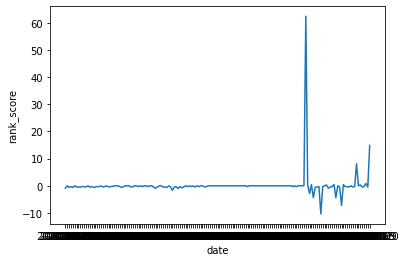

In [345]:
inp = input('enter player: ').lower()
plyr_df = test.loc[(test['player_name'].str.lower() == inp) & (test['date'] >= '2021-10-30')]
sns.lineplot(data=plyr_df, x='date', y='rank_score')
print(sum(plyr_df['rank_score']))
plyr_df

In [340]:
t = test.loc[test['date'] >= '2021-10-30']
t[['player_id','player_name','rank_score']].groupby(['player_id','player_name']).agg(sum).sort_values(by='rank_score').reset_index()

,player_id,player_name,rank_score
0,1629004,Svi Mykhailiuk,-49.9500
1,1626158,Richaun Holmes,-48.7665
2,202689,Kemba Walker,-47.7301
3,1629717,Armoni Brooks,-47.2501
4,1629308,Juan Toscano-Anderson,-46.3500
...,...,...,...
532,1630678,Terry Taylor,51.0001
533,1627745,Damian Jones,56.6810
534,1630570,Trendon Watford,63.7547
535,1630595,Cade Cunningham,66.5835
